In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 46.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [ ]:
from google.colab import drive
drive.mount('MyDrive')
%cd MyDrive/MyDrive

Mounted at MyDrive
/content/MyDrive/MyDrive


In [ ]:
import networkx as nx
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data, DataLoader

In [ ]:
PATH = 'Data/DG_1D_Data'
NUM_FILES = 10000


def DataItem(index):
  data = np.load(PATH + '/'  + str(index) + '.npy', allow_pickle = True)
  data = data[()]
  u = data['u']
  u = (u - u.min())/(u.max() - u.min()) # Min-Max Normalization
  labels = data['labels']
  labels = np.concatenate([[0], labels])
  advectionSpeed = data['advectionSpeed']
  finalTime = data['finalTime']
  h = 1/100
  labels = labels * h
  labels = labels + advectionSpeed*finalTime
  labels = np.divmod(labels, 1)[1]
  y = np.zeros((100, ))
  labels = np.floor(labels/h)
  labels = list(map(int, labels))
  for label in labels:
    y[label] = 1
  y = torch.tensor(y).long()
  # lis = random.sample(range(100), 2)
  # lis = [random.sample(range(max(min(labels) - 1, 0) + 1), 1)[0], random.sample(range(min(max(labels) + 1, 99), 100), 1)[0]]
  # left, right = lis
  left =0
  right =99

  u = u[:, left : right + 1]
  u = u.T
  y = y[left : right + 1]
  rows = list(range(0, right - left)) + list(range(1 , right - left + 1))
  cols = list(range(1 , right - left + 1)) + list(range(0, right - left))
  edges = torch.tensor([rows, cols])
  u = torch.tensor(u.astype(np.float64)).double()
  y = torch.tensor(y).double()
  graph = Data(x = u, edge_index = edges, y = y)
  return graph

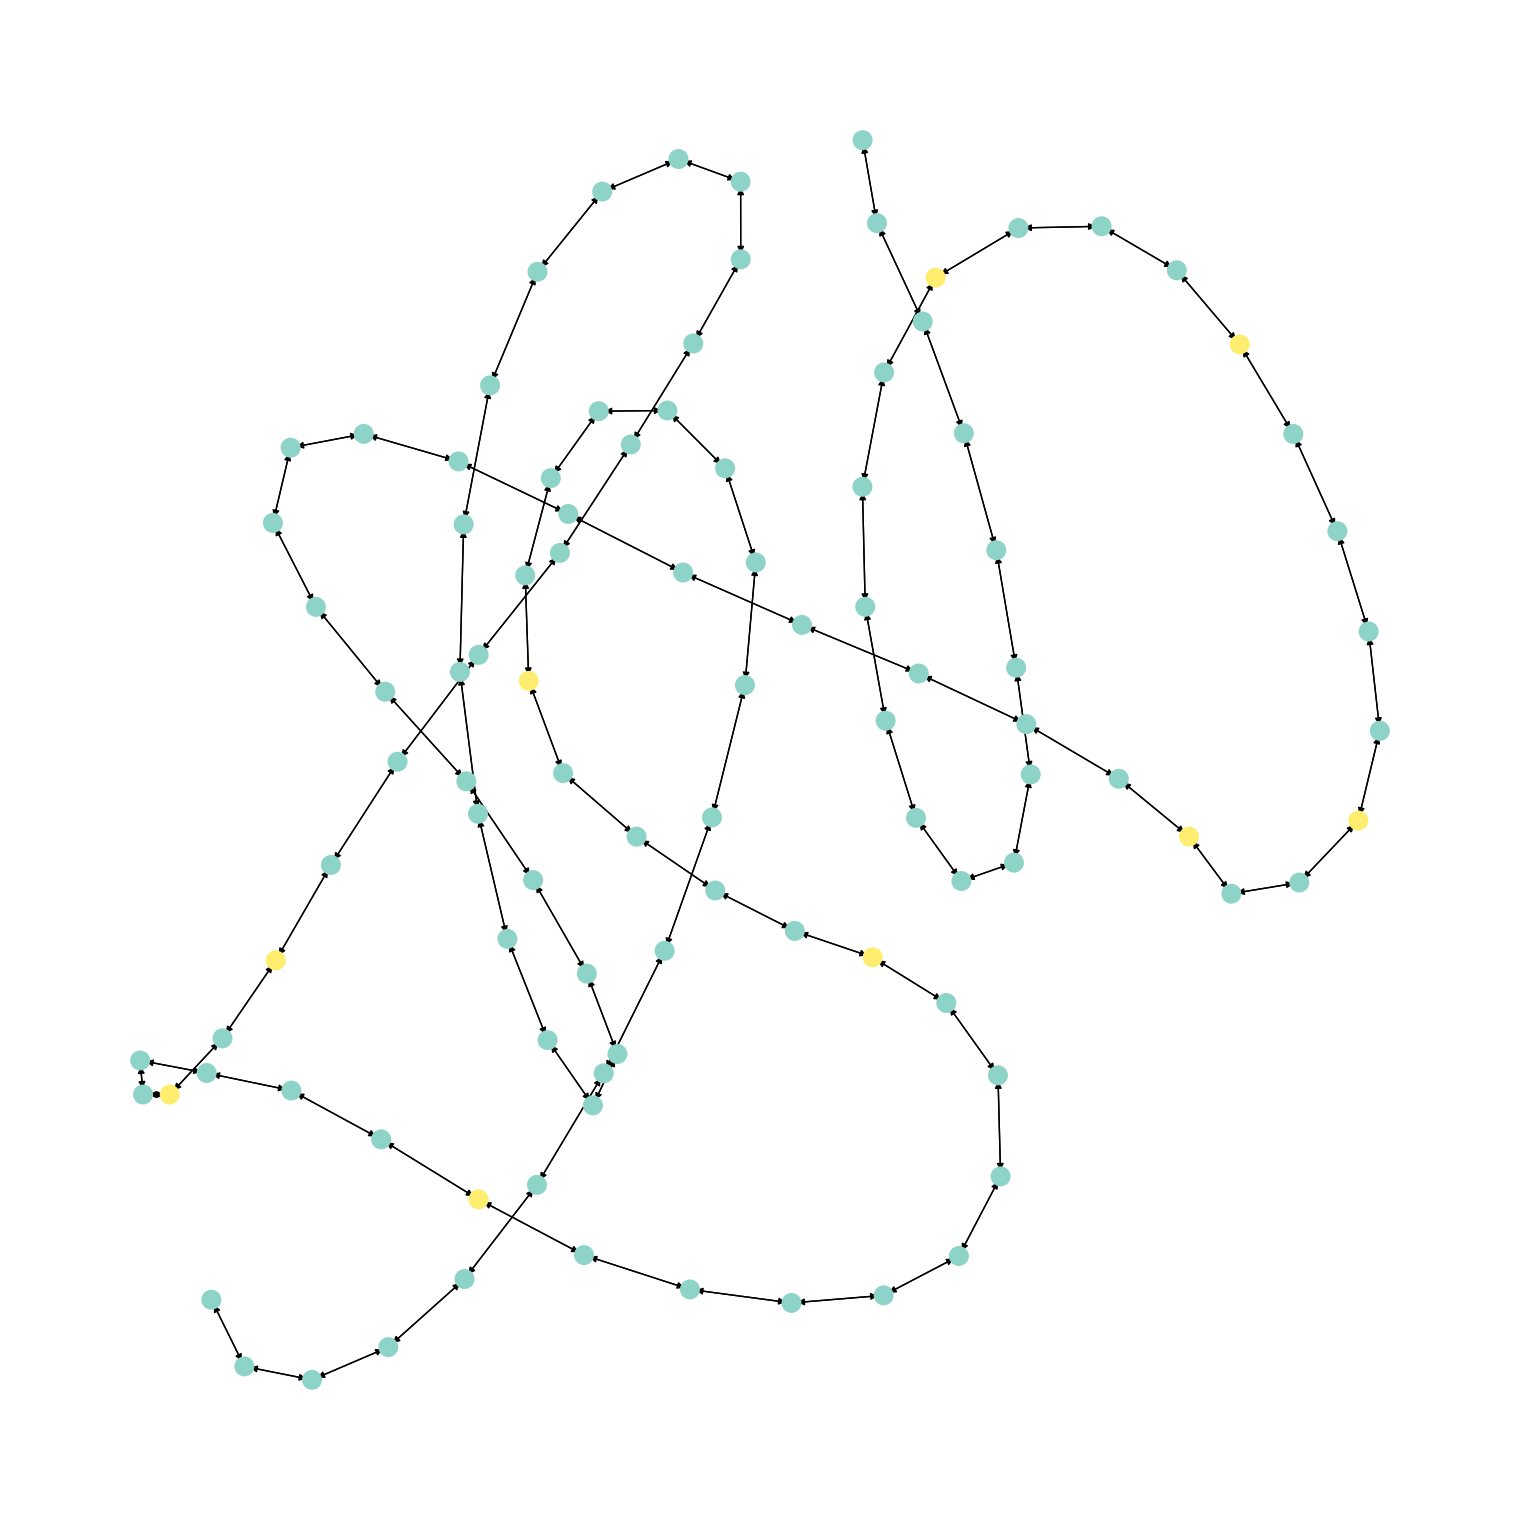

In [ ]:
graph = DataItem(35)
vis = to_networkx(graph)
node_labels = graph.y.numpy()
import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,15))
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.show()


In [ ]:
from torch_geometric.nn import GATConv
class GATModel(nn.Module):
  def __init__(self):
    super(GATModel, self).__init__()
    self.conv1 = GATConv(
        in_channels = 9,
        out_channels = 24,
        heads = 8,
        dropout = 0.2
    )
    self.conv2 = GATConv(
        in_channels = 24 * 8,
        out_channels = 2,
        concat  = False
    )

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    type(x)
    # x = torch.tensor(x)
    x = self.conv1(x, edge_index)
    x = torch.nn.ELU()(x)
    x = self.conv2(x, edge_index = edge_index)


    return nn.LogSoftmax(dim = 1)(x)






In [ ]:
class DiscontModel(nn.Module):

  def __init__(self):
    super(DiscontModel, self).__init__()
    self.layer1 = nn.Conv1d(in_channels = 9, out_channels = 24, kernel_size = 2)
    self.layer2 = nn.Conv1d(in_channels = 24,out_channels = 24, kernel_size = 2)
    self.layer3 = nn.Conv1d(in_channels = 24, out_channels = 24, kernel_size = 2)
    self.layer4 = nn.Conv1d(in_channels = 24, out_channels = 24, kernel_size =2)
    self.flatter = nn.Flatten()
    self.layer5 = nn.Linear(in_features = 96*24, out_features = 100)

  def forward(self, x):
    out1 = self.layer1(x)
    out1 = nn.ReLU()(out1)
    # print(f'out1.shape : {out1.shape}')
    out2 = self.layer2(out1)
    out2 = nn.ReLU()(out2)
    # print(f'out.shape : {out2.shape}')
    out3 = self.layer3(out2)
    out3 = nn.ReLU()(out3)
    # print(f'out3.shape : {out3.shape}')
    out4  = self.layer4(out3)
    out4 = nn.ReLU()(out4)
    flat = self.flatter(out4)
    # print(f'out.shape : {flat.shape}')
    out = self.layer5(flat)

    out = nn.Sigmoid()(out)
    return out


In [ ]:
Cnnmodel = DiscontModel()
Cnnmodel.load_state_dict(torch.load('best_model_2.pt',map_location = torch.device('cpu')))
Cnnmodel.double()

DiscontModel(
  (layer1): Conv1d(9, 24, kernel_size=(2,), stride=(1,))
  (layer2): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
  (layer3): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
  (layer4): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
  (flatter): Flatten(start_dim=1, end_dim=-1)
  (layer5): Linear(in_features=2304, out_features=100, bias=True)
)

In [ ]:
def cnnPredict(u):
  u = (u - u.min())/(u.max() - u.min()) # MinMaxNormalization
  u = torch.tensor(u.astype(np.float32)).double()
  u = torch.unsqueeze(u,0)
  pred = Cnnmodel(u)
  return pred>0.1

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch_geometric.nn import GATConv
class GATModelNew(nn.Module):
  def __init__(self):
    super(GATModelNew, self).__init__()
    self.conv1 = GATConv(
        in_channels = 9,
        out_channels = 32,
        heads = 10,
        dropout = 0.2
    )
    self.conv2 = GATConv(
        in_channels = 32 * 10,
        out_channels = 1,
        concat  = False
    )

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    # x = torch.tensor(x)
    x = self.conv1(x, edge_index)
    x = torch.nn.ELU()(x)
    x = self.conv2(x, edge_index = edge_index)
    x = nn.Sigmoid()(x)
    return x






In [ ]:
model = GATModelNew()
model.load_state_dict(torch.load('GNN_ModelNew.pt', map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model.double()
model(graph).shape

torch.Size([100, 1])

In [ ]:
def predict(u):
  u = (u - u.min())/(u.max() - u.min()) # Min-Max Normalization
  h = 1/100
  # lis = random.sample(range(100), 2)
  # lis = [random.sample(range(max(min(labels) - 1, 0) + 1), 1)[0], random.sample(range(min(max(labels) + 1, 99), 100), 1)[0]]
  # left, right = lis
  left =0
  right =99
  u = u[:, left : right + 1]
  u = u.T
  rows = list(range(0, right - left)) + list(range(1 , right - left + 1))
  cols = list(range(1 , right - left + 1)) + list(range(0, right - left))
  edges = torch.tensor([rows, cols])
  u = torch.tensor(u.astype(np.float64)).double()
  graph = Data(x = u, edge_index = edges)
  # graph.x = u
  model.eval()
  pred = model(graph)
  return pred.detach().numpy() > 0.5

In [ ]:
from tqdm.notebook import tqdm
def calculateAccuracy():
  tp, tn, fp, fn = 0, 0, 0, 0
  for i in tqdm(range(9501, 10001)):
    data = np.load(PATH + '/'  + str(i) + '.npy', allow_pickle = True)
    data = data[()]
    u = data['u']
    labels = data['labels']
    labels = np.concatenate([[0], labels])
    advectionSpeed = data['advectionSpeed']
    finalTime = data['finalTime']
    h = 1/100
    labels = labels * h
    labels = labels + advectionSpeed*finalTime
    labels = np.divmod(labels, 1)[1]
    y = np.zeros((100, ))
    labels = np.floor(labels/h)
    labels = list(map(int, labels))
    for label in labels:
      y[label] = 1
    y = y.astype(np.uint8)
    out = predict(u)
    out = out.squeeze(1)
    # print(out.shape, batch.y.shape)
    # break
    tp += np.sum((out > 0.1) & (y == 1))
    tn += np.sum((out < 0.1) & (y == 0))
    fn += np.sum((out < 0.1) & (y == 1))
    fp += np.sum((out > 0.1) & (y == 0))
  return tp, tn, fp, fn


In [ ]:
tp, tn, fp, fn = calculateAccuracy()
print(tp, tn, fp, fn)

  0%|          | 0/500 [00:00<?, ?it/s]

2393 46593 756 258


In [ ]:
prec = tp*100/(tp + fp)
rec = tp * 100/(tp + fn)
print(f'Accuracy : {(tp + tn)*100/(tp + tn + fp + fn) : 0.2f}%')
print(f'Precision : {prec : 0.2f}%')
print(f'Recall : {rec : 0.2f}%')
print(f'F1 score : {2 * (rec * prec)/(rec + prec) : 0.2f}%')

Accuracy :  97.97%
Precision :  75.99%
Recall :  90.27%
F1 score :  82.52%


In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.sparse import csr_matrix, identity, find
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
def sub2ind(sz, row, col):
    n_rows = sz[0]
    return [n_rows * c + r for r, c in zip(row, col)]
def JacobiP(x, alpha, beta, N):
    '''
    Calculates the value of jacobi polynomial of type alpha, beta at points x
    for  order N.
    x: Numpy array
    '''
    xp = x.reshape(1, -1)
    n = xp.shape[1]
    PL = np.zeros((N+ 1, n))

    gamma0 = np.power(2, alpha + beta + 1)/(alpha + beta + 1) *gamma(alpha + 1) * gamma(beta + 1)/gamma(alpha + beta + 1)
    PL[0, :] = 1.0/np.sqrt(gamma0)
    if N == 0:
        return PL.T

    gamma1 = (alpha + 1)*(beta + 1)/(alpha + beta +3)* gamma0

    PL[1, :] = ((alpha + beta +  2) * xp/2 + (alpha - beta)/2)/np.sqrt(gamma1)

    if N == 1:
        return PL[N, :]

    aold = 2/(2 + alpha + beta) * np.sqrt((alpha + 1) *(beta + 1)/(alpha + beta + 3))
    for i in range(N - 1):
        h1 = 2*(i + 1) + alpha + beta
        anew = 2/(h1 + 2) * np.sqrt((i + 2) * (i+2 + alpha + beta) * (i + 2 + alpha) *(i + 2 + beta)/(h1 + 1)/(h1 + 3))
        bnew = -(alpha ** 2 - beta**2)/h1/(h1 + 2)
        PL[i + 2, : ] = 1/(anew) *(-aold * PL[i, :] + (xp - bnew) *PL[i + 1, :])
        aold = anew
    return PL[N, :]

def JacobiGQ(alpha, beta, N):
    '''
    Computes the Nth order Guass Quadrature points(x) and the
    associated weights(w), associated with the Jacobi polynomial of type (alpha, beta)
    '''
    if N == 0:
        zer = (alpha - beta)/(alpha + beta + 2)
        wt = 2
        return np.array([zer]), np.array([wt])


    J = np.zeros((N + 1, N + 1))
    brr = np.array(range(1, N + 1))
    h1 = 2 * np.array(range(N  + 1)) + alpha + beta
    J = np.diag(-1/2 * (alpha ** 2 - beta ** 2)/(h1 + 2)/h1) + np.diag(
        2/(h1[:N]  + 2) * np.sqrt(brr * (brr  + alpha + beta )*(brr + alpha) * (brr + beta)/(h1[:N] + 1)/(h1[:N] + 3)), 1
        )
    eps = 1e-5
    if alpha + beta < 10 * eps:

        J[0, 0] = 0
    J = J + J.T

    D, V = np.linalg.eig(J)
    x = D
    w = np.power(V[0, :].T, 2) * (2**(alpha + beta + 1))/(alpha + beta + 1) * gamma(alpha  + 1) * gamma(beta + 1)/gamma(alpha + beta + 1)
    return x, w


def JacobiGL(alpha, beta, N):
    '''
    Computes the Nth order Gauss Lobato quadrature points(x), associated
    with the Jacobi polynomial of type (alpha, beta)
    '''
    x = np.zeros((N + 1, 1))
    if N == 1:
        return np.array([-1, 1])
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N - 2)
    ind = xint.argsort(axis = None)
    xint = xint[ind]
    x = np.concatenate(([-1], xint, [1]))

    return x

def MeshGen1D(xmin, xmax, K):
    '''
    Function to generate mesh with K elements which are equidistant
    '''
    Nv = K + 1
    VX = np.array(range(Nv), dtype = np.float128)
    for i in range(Nv):
        VX[i] = (xmax - xmin) *(i)/(Nv - 1) + xmin
    EToV = np.zeros((K, 2))
    for k in range(K):
        EToV[k, 0] = k
        EToV[k, 1] = k + 1
    return Nv, VX, K, EToV



def Vandermonde1D(N, r):
    '''
    Function to calculate the vandermonde martrix
    V_{ij} = phi_j(r_i)
    '''
    n = max(r.shape)
    V1D = np.zeros((n, N + 1))
    for j in range(N + 1):
        V1D[:, j] = JacobiP(r, 0, 0,j ).reshape((n, ))
    return V1D

def GradJacobiP(r, alpha, beta, N):
    '''
    Function to calculate the derivative of the jacobi polynomial
    of type (alpha, beta) at points r for order N and returns
    '''
    r = r.reshape(-1, 1)
    dP = np.zeros(r.shape)
    if N == 0:
        dP[:, :] = 0.0
    else:
        dP = np.sqrt(N*(N + alpha + beta + 1)) * JacobiP(r, alpha + 1, beta + 1, N  - 1)

    return dP

def GradVandermonde1D(N, r):
    '''
    Initialize the gradient of the modal basis (i) at (r) at order N
    '''
    n = max(r.shape)
    DVr = np.zeros((n, N+ 1))
    for i in range(N + 1):
        DVr[:, i ] = GradJacobiP(r, 0, 0, i).reshape((n,))
    return DVr


def Dmatrix1D(N, r, V):
    '''
    Function to calculate the differentiation matrix on the interval,
    evaluated at (r) at order N
    '''
    Vr = GradVandermonde1D(N, r)
    Dr = Vr @ np.linalg.pinv(V)
    return Dr


def Lift1D():
    '''
    Compute surface integral term in dg-formulation
    '''
    global Np, Nfaces, Nfp
    global V
    Emat = np.zeros((Np, Nfaces * Nfp))

    Emat[0, 0] = 1.0
    Emat[Np -1, 1] = 1.0

    Lift = V@(V.T @ Emat)
    return Lift





def GeometricFactors1D(x, Dr):
    '''
    Computes the metric elements for the local mappings
    of the 1D elements
    '''
    xr = Dr@x
    J = xr
    rx = 1/J
    return rx, J




def Normals1D():
    global Nfp, Nfaces, K
    nx = np.zeros((Nfp*Nfaces, K))
    nx[0, :] = -1.0
    nx[1, :] = 1.0
    return nx






def Connect1D(EToV):
    '''
    Build Global connectivity arrays for 1D grid based on standard
    EToV input array from grid generator
    '''
    global Nfaces
    K = EToV.shape[0]
    TotalFaces = Nfaces*K
    Nv = K + 1
    vn = np.array([0, 1])

    sk = 1
    rows = []
    cols = []
    sk = 0
    for k in range(K):
        for face in range(Nfaces):
            rows.append(sk)
            cols.append(EToV[k, vn[face]])
            sk += 1
    data = [1]*len(cols)
    SpFToV = csr_matrix((data, (rows, cols)), shape = (TotalFaces, Nv))

    SpFToF = SpFToV@(SpFToV.T) - identity(TotalFaces)

    faces1 , faces2, _ = find(SpFToF == 1)
    element1 = faces1//Nfaces
    face1    = faces1%Nfaces
    element2 = faces2//Nfaces
    face2    = faces2 % Nfaces
    ind = sub2ind([K, Nfaces], element1, face1)
    ind = np.array(ind)
    EToE = np.array(range(K)).reshape(-1, 1)@np.ones((1, Nfaces))
    EToF = np.ones((K, 1))@np.array(range(Nfaces)).reshape(1, -1)
    EToE[ind%K, ind//K] = element2
    EToF[ind%K, ind//K] = face2
    return EToE, EToF


def BuildMaps1D():
    global K, Np, Nfaces, Nfp, NODETOL
    global EToE, EToV, EToF
    global Fmask
    global x


    nodeids = np.array(range(K*Np)).reshape(Np, K, order = 'F')
    vmapM = np.zeros((Nfp, Nfaces, K))
    vmapP = np.zeros((Nfp, Nfaces, K))
    for k1 in range(K):
        for f1 in range(Nfaces):
            vmapM[:, f1, k1] = nodeids[Fmask[f1], k1]



    for k1 in range(K):
        for f1 in range(Nfaces):
            k2 = int(EToE[k1, f1])
            f2 = int(EToF[k1, f1])

            vidM = vmapM[:, f1, k1]
            vidP = vmapM[:, f2, k2]
            vidM = vidM.astype(np.uint16)
            vidP = vidP.astype(np.uint16)
            vidM_ = np.unravel_index(vidP, x.shape, 'F')
            vidP_ = np.unravel_index(vidP , x.shape, 'F')
            x1 = x[vidM_]
            x2 = x[vidP_]
            D = (x1 -x2)**2
            if D < NODETOL:
                vmapP[:, f1, k1] = vidP

    vmapP = vmapP.ravel('F')
    vmapM = vmapM.ravel('F')
    mapB = np.where(vmapP == vmapM)
    global vmapB, mapI, map0, vmapI, vmap0
    vmapB = vmapM[mapB]
    mapI = 0
    map0 = K*Nfaces - 1
    vmapI = 0
    vmap0 = K*Np - 1

    return vmapM, vmapP, vmapB, mapB

def Globals1D():
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF
    global V, invV
    global NODETOL

    rk4a = np.array([
        0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0
    ])
    rk4b = np.array([
        1432997174477.0/9575080441755.0,
        5161836677717.0/13612068292357.0,
        1720146321549.0/2090206949498.0,
        3134564353537.0/4481467310338.0,
        2277821191437.0/14882151754819.0
    ])
    rk4c = np.array([
         0.0,
         1432997174477.0/9575080441755.0,
         2526269341429.0/6820363962896.0,
         2006345519317.0/3224310063776.0,
         2802321613138.0/2924317926251.0
    ])
    NODETOL = 1e-10


def StartUp1D():
    Globals1D()
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF, EToV
    global V, invV
    global NODETOL
    Np = N + 1
    Nfp = 1
    Nfaces = 2
    r = JacobiGL(0, 0, N)
    V = Vandermonde1D(N, r)
    invV = np.linalg.pinv(V)
    Dr = Dmatrix1D(N, r, V)
    LIFT = Lift1D()
    va = EToV[:, 0].reshape(1, -1)
    va = va.ravel()
    vb  = EToV[:, 1].reshape(1, -1)
    vb = vb.ravel()

    fmask1 = np.where(abs(1 + r)< NODETOL)
    fmask2 = np.where(abs(1  - r) < NODETOL)
    Fmask = [fmask1[0][0], fmask2[0][0]]

    r = r.reshape(-1, 1)
    x = np.ones((N + 1, 1)) @( VX[va.astype(np.uint8)].reshape(1, -1)) + 0.5 * ( 1 + r) @ ((VX[vb.astype(np.uint8)] - VX[va.astype(np.uint8)]).reshape(1, - 1))

    rx, J = GeometricFactors1D(x, Dr)

    EToE, EToF = Connect1D(EToV)
    Fx = x[np.ravel(np.array(Fmask)), :]

    nx = Normals1D()

    Fscale = 1/J[np.array(Fmask), :]
    vmapM, vmapP, vmapB, mapB = BuildMaps1D()



def AdvecRHS1D(u, time, a):
    '''
    Evaluate the RHS flux in 1D Advection
    '''
    global Nfp, Nfaces, K
    global vmapP, vmapM, vmapB, mapB
    global mapI, vmapI, map0, vmap0
    global Dr
    global nx
    global bc




    alpha = 0.5
    vmapM = vmapM.astype(np.int16)
    vmapP = vmapP.astype(np.int16)
    # mapI = mapI.astype(np.int16)
    # map0 = map0.astype(np.int16)
    vmapM_ = np.unravel_index(vmapM, u.shape, 'F')
    vmapP_ = np.unravel_index(vmapP, u.shape, 'F')

    du = ((u[vmapM_]  - u[vmapP_]).reshape(nx.shape, order = 'F')) * (a * nx - (1 - alpha)* np.abs(a * nx))/2


    uin = bc(-a * time)
    mapI_ = np.unravel_index(mapI, du.shape, 'F')
    map0_ = np.unravel_index(map0, du.shape, 'F')
    vmapI_ = np.unravel_index(vmapI, du.shape, 'F')
    du[mapI_] = (u[vmapI_] - uin)*(a* nx[mapI_] - (a - alpha) * np.abs(a * nx[mapI_]))/2

    map0_  = np.unravel_index(map0, du.shape, 'F')
    du[map0_] = 0

    rhsu = - a* rx * (Dr@u) + LIFT@(Fscale * du)
    # print(f"Fmask : {Fmask}")
    # print(f"Fscale : {Fscale}")
    # print(f'J : {J}')
    # print(f"r : {r}")
    return rhsu



def Advec1D(u, a, finalTime):
    time = 0
    global Nfp, Nfaces, K
    global vmapP, vmapM, vmapB, mapB
    global mapI, vmapI, map0, vmap0
    global Dr
    global nx
    global bc
    global rk4c
    global N

    global TCI, U
    TCI = []
    U = []
    resu = np.zeros((Np, K))
    xmin = min(abs(x[0, :] - x[1, :]))

    CFL  = 0.75
    dt = (CFL/a)*xmin
    dt = 0.5 * dt
    Nsteps = np.ceil(finalTime/dt)
    dt = finalTime/Nsteps
    print(f'dt : {dt}')
    Nsteps = int(Nsteps)
    for tstep  in range(Nsteps):
        for INTRK in range(5):
            timelocal = time + rk4c[INTRK]*dt


            rhsu = AdvecRHS1D(u, timelocal, a)
            resu = rk4a[INTRK] * resu + dt * rhsu

            u = u + rk4b[INTRK] * resu
        u = SlopeLimitN(u, None)
        # pred = predict(u)
        # pred = pred.squeeze()
        # TCI.append(np.where(pred))
        # U.append(u)
        time = time + dt

    return u

def sin2npi(x):
  return np.sin(2 * np . pi * x)
def AdvecDriver1D():
    Globals1D()
    global N, Nfp, Np, K
    global r , x , VX
    global Dr, LIFT
    global nx, Fx, Fscale
    global vmapM, vmapP, vmapB, mapB, Fmask
    global vmapI, vmap0, mapI, map0
    global rx, J
    global rk4a, rk4b, rk4c
    global Nfaces, EToE, EToF, EToV
    global V, invV
    global NODETOL
    global bc
    bc = np.sin
    N = 8
    Nv, VX, K, EToV = MeshGen1D(0.0, 2.0 * np.pi, 10)
    StartUp1D()
    # print(f"V : {V}")
    u = np.sin(x)
    finalTime = 0.8
    u = Advec1D(u, 2*np.pi, finalTime)

    from matplotlib import pyplot as plt
    plt.plot(x.ravel('F'), u.ravel('F'), 'x')
    plt.plot(x.ravel('F'), np.sin(  x).ravel('F'))
    plt.plot(x.ravel('F'), np.sin( x- 2 * np.pi * finalTime ).ravel('F'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['FinalTime ', 'Time 0', 'Expect'])
    plt.show()




# AdvecDriver1D()
# # StartUp1D

def minmodB(v, h,M = 1):
  mfunc = v[0, :]
  ids = np.where(np.abs(mfunc) > M*(h**2))
  if len(ids[0])>0:
    mfunc[ids] = minmod(v[:, ids])
  return mfunc
def minmod(v):
    m = v.shape[0]
    mfunc = np.zeros((1, v.shape[1]))
    s = np.sum(np.sign(v), axis = 0)/m

    ids = np.where(np.abs(s) == 1)
    if len(ids) != 0:
        mfunc[0, ids] = s[ids] * np.min(abs(v[:, ids]), axis = 0)

    return mfunc


def SlopeLimitLin(ul, x1, vm1, v0, vp1):
    global Np
    global Dr
    ulimit = ul
    h = x1[Np - 1, :] - x1[0, :]
    x0 = np.ones((Np, 1)) @ ((x1[0,:] + h/2 ).reshape(1, -1))
    hN = np.ones((Np, 1)) @ (h.reshape(1,-1))
    ux = (2/hN) * (Dr @ ul)
    ulimit = np.ones((Np, 1))@v0.reshape(1, -1) + (x1 - x0) * (np.ones((Np, 1))@(minmod(np.array([ux[0, :], (vp1 - v0)/h, (v0 - vm1)/h]))))
    return ulimit
def SlopeLimitN(u,model):
    global V, invV
    global Np
    global x

    uh = invV@u
    uh[1:Np, :] = 0
    uavg = V@uh
    v = uavg[0, :]


    ulimit = u
    eps0 = 1e-8

    ue1 = u[0, :]
    ue2 = u[-1, :]
    vk = v
    vkm1 = np.concatenate(([v[ 0]], v[0: K -1 ]))
    # v = v.squeeze()
    vkp1 = np.concatenate((v[1:K],[v[K - 1]]))
    # pred = predict(ulimit) #GNN Model predictions
    pred = cnnPredict(ulimit)#CNN Model Prediction
    pred = pred.squeeze()
    ids = np.where(pred)[0]

    # ve1 = vk - minmod(np.array([(vk - ue1),vk-vkm1, vkp1 - vk]))
    # ve2 = vk + minmod(np.array([(ue2 - vk),vk-vkm1, vkp1 - vk]))
    # ids = np.where((np.abs(ve1 - ue1) > eps0) | (np.abs(ve2 - ue2)>eps0))[1]
    TCI.append(ids)
    U.append(ulimit)
    if len(ids) != 0:
        # print(ids)
        uh1 = invV@u[:, ids]
        uh1[2:Np, :] = 0
        u1 = V@uh1
        ulimit[:, ids ] = SlopeLimitLin(u1, x[:, ids], vkm1[ids], vk[ids], vkp1[ids])
    return ulimit


# AdvecDriver1D()


In [ ]:
def SolveAdvection(f, finalTime, advectionSpeed, plot = False):
  Globals1D()
  global N, Nfp, Np, K
  global r , x , VX
  global Dr, LIFT
  global nx, Fx, Fscale
  global vmapM, vmapP, vmapB, mapB, Fmask
  global vmapI, vmap0, mapI, map0
  global rx, J
  global rk4a, rk4b, rk4c
  global Nfaces, EToE, EToF, EToV
  global V, invV
  global NODETOL
  global bc
  bc = f
  Nv, VX, K, EToV = MeshGen1D(0.0, 1, 100)
  StartUp1D()
  u = f(x)
  u = Advec1D(u, advectionSpeed, finalTime)
  if plot:

    from matplotlib import pyplot as plt
    plt.plot(x.ravel('F'), u.ravel('F'), 'x', markersize = 1)
    plt.plot(x.ravel('F'), f(x).ravel('F'))
    plt.plot(x.ravel('F'), f( x-advectionSpeed * finalTime ).ravel('F'))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['FinalTime ', 'Time 0', 'Expect'])
    plt.show()
  return u



In [ ]:
np.where(pred)

(array([39, 60]), array([0, 0]))

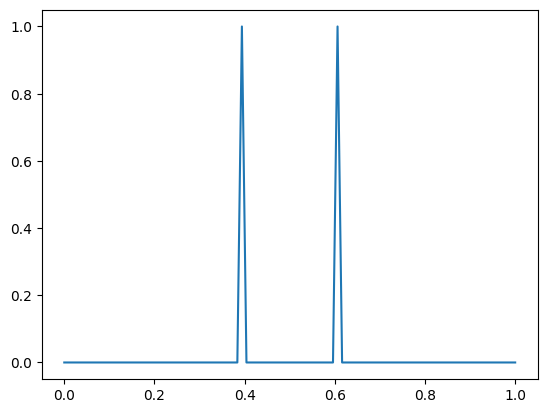

In [ ]:
u = f(x)
pred = predict(u)
plt.plot(np.linspace(0, 1, 100), pred)

dt : 0.00018789928598271326


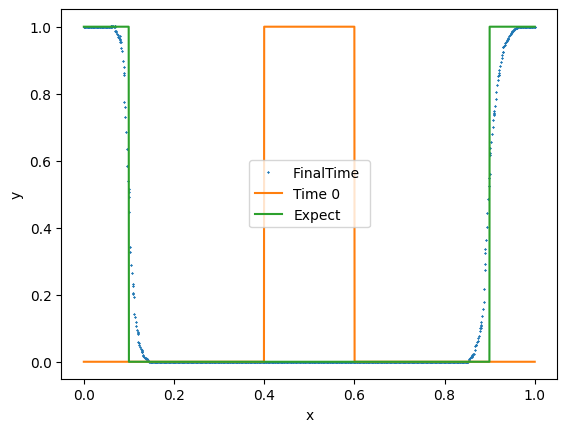

In [ ]:
TCI =[]
def f(x):
  x = np.divmod(x, 1)[1]
  # if 0.4 <= x <= 0.6:
  #   return 1
  # return 0
  return np.piecewise(x, [(x<0.4) & (x>0.6) , (0.4<=x) & (x<=0.6)], [0, 1])
# f = np.frompyfunc(fp, 1, 1)



# f = lambda x : np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x)
finalTime = 0.5
advectionSpeed = 1
global N
N = 8
u = SolveAdvection(f, finalTime, advectionSpeed, plot = True)

In [ ]:
dt = finalTime/len(TCI)


In [ ]:
len(U), len(TCI)

(2661, 2661)

In [ ]:
%pwd

'/content/MyDrive/MyDrive'

In [ ]:
di = {'U' : U, 'TCI' : TCI}
np.save('newanime.npy', di)

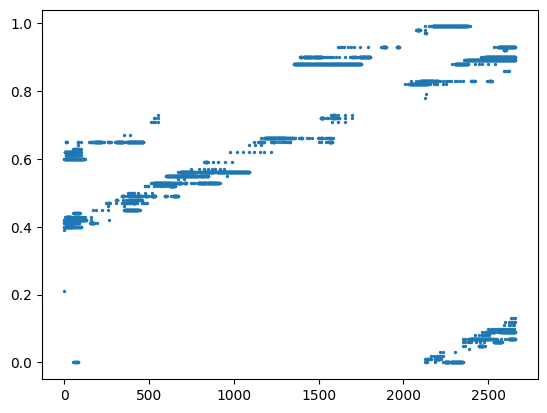

In [ ]:
xx = []
yy = []
for i, cells in enumerate(TCI):
  for cell in cells:
    xx.append(i)
    yy.append(cell*0.01)
plt.scatter(xx, yy, s = 2)

In [ ]:
TCI[0]

array([39, 40, 60])

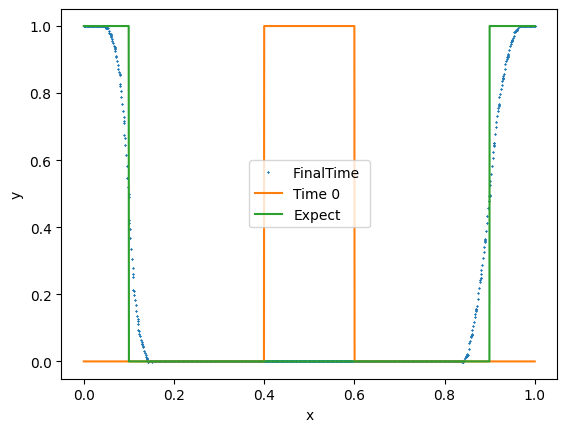

In [ ]:

def f(x):
  x = np.divmod(x, 1)[1]
  # if 0.4 <= x <= 0.6:
  #   return 1
  # return 0
  return np.piecewise(x, [(x<0.4) & (x>0.6) , (0.4<=x) & (x<=0.6)], [0, 1])
# f = np.frompyfunc(fp, 1, 1)



# f = lambda x : np.sin(2 * np.pi * x) + np.cos(2 * np.pi * x)
finalTime = 0.5
advectionSpeed = 1
global N
N = 8
u = SolveAdvection(f, finalTime, advectionSpeed, plot = True)

In [ ]:
x.shape

(9, 100)

In [ ]:
graph.x.shape

torch.Size([100, 9])

In [ ]:
def VisualizePrediction(index):
  graph = DataItem(index)
  pred = model(graph)
  pred = pred>0.1
  label = graph.y
  data = np.load(PATH + '/'  + str(index) + '.npy', allow_pickle = True)
  data = data[()]
  u = data['u']
  plt.plot(x.ravel('F'),u.ravel('F'))
  pred = pred.detach().numpy()
  plt.plot(np.linspace(0, 1, 100) + 0.005, pred)
  plt.legend(['Functional Data', 'Predicted Labels'])
  plt.show()

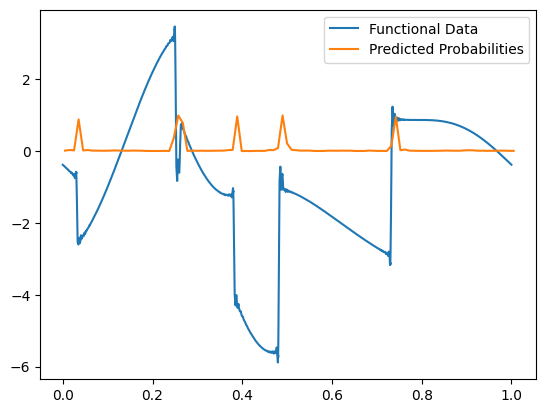

In [ ]:
VisualizePrediction(100)

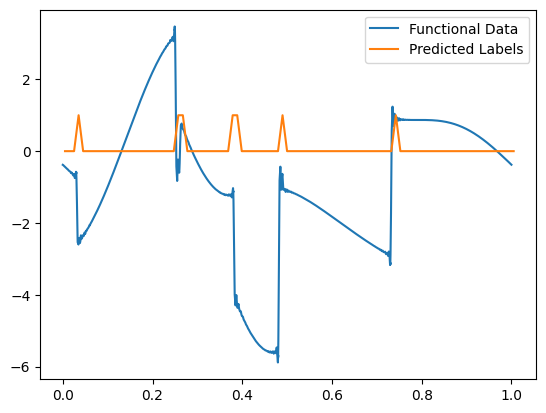

In [ ]:
VisualizePrediction(100)